<a href="https://colab.research.google.com/github/Sarvesh1814/DeepNeuralNLP/blob/Assignment-1-Train-Word2Vec-on-peS2o-Dataset-(AllenNLP)/IT555_Deep_Neural_NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Train Word2Vec on peS2o Dataset (AllenNLP)

# Team Name: Data Demystifires

|Name|Student ID|
|--|--|
|Sarvesh Bagwe|202211006|
|Vedant Dave| 202211042|
|Hiren Thakkar| 202211074|
|Kashyap Halvadia|202003040|

# 0. References for this assignment


1.   @misc{wang2023pes2o,
title = {pes2o: A Large-Scale Dataset of Pre-trained Sentences for Open-domain Question Answering},
author = {Jiaheng Wang, Zihang Wang, Zihang Wang, Jianfeng Gao, Yi Tay, Christopher R. Manning},
year = {2023},
url = {https://arxiv.org/abs/2307.14027}
}   [Dataset]

2. https://docs.python.org/3/library/gzip.html [gzip documentation]

3. https://stackoverflow.com/questions/37011734/pandas-dataframe-str-contains-and-operation [string searching in pandas]

4. https://pypi.org/project/num2words/ [Numeric to words documentation]

5. https://medium.com/factory-mind/regex-tutorial-a-simple-cheatsheet-by-examples-649dc1c3f285 [ Regex Patterns]

6. https://regex101.com/ [Testing Regex Patterns]

7. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html [ Train Test Split SKlearn]

8. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html [ TFIDF Vectorizer Sklearn]

9.  https://towardsdatascience.com/implementing-word2vec-in-pytorch-from-the-ground-up-c7fe5bf99889 [Word2Vec]


# 1. Downloading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gzip
import json
file_name = "/content/drive/MyDrive/validation-00000-of-00002.json.gz"
data = []

with gzip.open(file_name, 'rb') as f:
    for line in f:
        json_obj = json.loads(line)
        data.append(json_obj)


In [3]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,id,source,version,added,created,text
0,254721023,s2ag/valid,v1,2022-12-16T16:07:05.559Z,2022-12-14T00:00:00.000Z,Investigation Some Characteristics of Biocompo...
1,254200673,s2ag/valid,v1,2022-12-04T16:21:43.441Z,2022-12-02T00:00:00.000Z,Modelling Techniques for Conjunctive Water Man...
2,252643161,s2ag/valid,v1,2022-10-01T15:18:53.788Z,2022-12-01T00:00:00.000Z,Complete Targets Coverage in Energy Harvesting...
3,244852373,s2ag/valid,v1,2021-12-04T16:21:39.980Z,2022-12-01T00:00:00.000Z,Nonorthogonal Multiple Access Enabled Two-Way ...
4,254774363,s2ag/valid,v1,2022-12-17T16:19:10.635Z,2022-12-14T00:00:00.000Z,106 A CASE OF COMPLETE ATRIOVENTRICULAR BLOCK ...


In [4]:
df.shape

(111228, 6)

# 2.  Fetching all the papers that are related to Computer Science domain using few keywords from the domain that match with the paper text

### This code get the field of study for every paper based on the doc id using the api but it works too slow.

In [5]:
# # Function to get the field of study for every paper based on the doc id
# import requests
# def get_field_of_study(corpus_id):
#     api_url = f'https://api.semanticscholar.org/v1/paper/CorpusID:{corpus_id}'
#     response = requests.get(api_url)
#     if response.status_code == 200:
#         document_data = response.json()
#         fields_of_study = document_data.get("fieldsOfStudy", [])
#         if document_data['s2FieldsOfStudy']:
#           return document_data['s2FieldsOfStudy'][0]['category']
#         return "None"
#     else:
#         return "None"

In [6]:
# # Fetching field of study for every row in the dataframe
# dx["fieldofstudy"] = dx["id"].apply(get_field_of_study)
# dx.head()

# It took 55 seconds for 100 rows so writing new optimised code

### Optimized code using threading and chunking of data for faster process

In [7]:
import requests
import concurrent.futures
import pandas as pd

# Function to get field of study for a single corpus_id
def get_field_of_study(corpus_id):
    api_url = f'https://api.semanticscholar.org/v1/paper/CorpusID:{corpus_id}'
    response = requests.get(api_url)
    if response.status_code == 200:
        document_data = response.json()
        fields_of_study = document_data.get("fieldsOfStudy", [])
        if document_data['s2FieldsOfStudy']:
            return document_data['s2FieldsOfStudy'][0]['category']
        return "None"
    else:
        return "None"

# Function to fetch field of study using parallel processing
def fetch_field_of_study_chunk(chunk, max_workers=10):
    field_of_study_list = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(get_field_of_study, chunk))
        field_of_study_list.extend(results)

    return field_of_study_list

# Function to process the DataFrame in chunks and save to CSV
def process_dataframe_in_chunks(df, output_csv, chunk_size=1000):
    num_chunks = len(df) // chunk_size + 1

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk_df = df.iloc[start_idx:end_idx]
        chunk_ids = chunk_df["id"].tolist()
        field_of_study_results = fetch_field_of_study_chunk(chunk_ids)
        chunk_df["fieldofstudy"] = field_of_study_results

        # Save the chunk to a CSV file
        if i == 0:
            chunk_df.to_csv(output_csv, mode="w", header=True, index=False)
        else:
            chunk_df.to_csv(output_csv, mode="a", header=False, index=False)

        print(f"Processed chunk {i + 1}/{num_chunks}")



In [8]:
# Saving the file as the whole process took 7 hours to complete
output_csv = "/content/drive/MyDrive/output_data1.csv"
process_dataframe_in_chunks(df, output_csv)


In [9]:
import pandas as pd
result_df = pd.read_csv("/content/drive/MyDrive/output_data.csv")
result_df.head()

,id,source,version,added,created,text,fieldofstudy
0,254721023,s2ag/valid,v1,2022-12-16T16:07:05.559Z,2022-12-14T00:00:00.000Z,Investigation Some Characteristics of Biocompo...,Materials Science
1,254200673,s2ag/valid,v1,2022-12-04T16:21:43.441Z,2022-12-02T00:00:00.000Z,Modelling Techniques for Conjunctive Water Man...,Computer Science
2,252643161,s2ag/valid,v1,2022-10-01T15:18:53.788Z,2022-12-01T00:00:00.000Z,Complete Targets Coverage in Energy Harvesting...,Computer Science
3,244852373,s2ag/valid,v1,2021-12-04T16:21:39.980Z,2022-12-01T00:00:00.000Z,Nonorthogonal Multiple Access Enabled Two-Way ...,Computer Science
4,254774363,s2ag/valid,v1,2022-12-17T16:19:10.635Z,2022-12-14T00:00:00.000Z,106 A CASE OF COMPLETE ATRIOVENTRICULAR BLOCK ...,Medicine


### Fetching papers from Computer Science domain

In [10]:
# Creating a dataframe that contains only the computer science papers as datarows
result_df = result_df[result_df["fieldofstudy"].str.lower().str.contains("computer science")]
result_df

,id,source,version,added,created,text,fieldofstudy
1,254200673,s2ag/valid,v1,2022-12-04T16:21:43.441Z,2022-12-02T00:00:00.000Z,Modelling Techniques for Conjunctive Water Man...,Computer Science
2,252643161,s2ag/valid,v1,2022-10-01T15:18:53.788Z,2022-12-01T00:00:00.000Z,Complete Targets Coverage in Energy Harvesting...,Computer Science
3,244852373,s2ag/valid,v1,2021-12-04T16:21:39.980Z,2022-12-01T00:00:00.000Z,Nonorthogonal Multiple Access Enabled Two-Way ...,Computer Science
6,252033565,s2ag/valid,v1,2022-09-03T15:09:09.625Z,2023-01-01T00:00:00.000Z,Event-Triggered Adaptive Output Feedback Contr...,Computer Science
18,255290365,s2ag/valid,v1,2022-12-31T16:09:26.680Z,2022-12-22T00:00:00.000Z,From MMU to MPU: Adaptation of the Pip Kernel ...,Computer Science
...,...,...,...,...,...,...,...
111185,254767173,s2ag/valid,v1,2022-12-17T16:07:24.184Z,2022-12-14T00:00:00.000Z,Quality Analysis of Small Maritime Target Dete...,Computer Science
111198,254435147,s2ag/valid,v1,2022-12-09T16:03:15.885Z,2022-12-06T00:00:00.000Z,Deep Learning Architecture for Flight Flow Spa...,Computer Science
111203,254201128,s2ag/valid,v1,2022-12-04T18:08:49.392Z,2022-12-02T00:00:00.000Z,Anticipating the antecedents of feedback-seeki...,Computer Science
111216,255047274,s2ag/valid,v1,2022-12-24T16:32:27.711Z,2022-12-20T00:00:00.000Z,Exact Solutions for the Generalized Atangana-B...,Computer Science


# 3. Random training data of 3000 documents are used, while a test dataset of 1000 documents is to be used. (Train Test Splitting)

**We will consider first 4000 rows only for our task and then we will split it into train and test set. Currently we have 12421 rows in the dataset**

In [11]:
data = result_df.iloc[:4000]

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=1000, random_state=42)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (3000, 7)
Test data shape: (1000, 7)


# 4. Preprocessing the dataset

1. stopwords
2. urls
3. bullets
4. apostrophe
5. hyphens
6. enumerations
7. numerical-to-text conversion
8. punctuations.

In [13]:
!pip install num2words
import re
import nltk
from nltk.corpus import stopwords
from num2words import num2words
nltk.download('stopwords')
stop_words = stopwords.words("english")

def preprocess_text(text):
    # Removing stopwords using Regex

    # stopwords = set(["a", "an", "the", "in", "on", "at", "to", "of", "for", "with", "by"])
    # text = " ".join([word for word in text.split() if word.lower() not in stopwords])

    # Removing stopwords using NLTK
    text= " ".join([word for word in text.split() if word.lower() not in stop_words])

    # Removing URLs
    text = re.sub(r'http\S+', '', text)

    # Removing bullets
    text = re.sub(r'\s•\s', ' ', text)

    # Removing apostrophes
    text = re.sub(r"'s\b", '', text)

    # Removing hyphens
    text = re.sub(r'-', ' ', text)

    # Remove enumerations
    text = re.sub(r'\b\d+\.\s*', '', text)

    # Converting numerical values to text
    text = re.sub(r'\d+', lambda x: num2words(int(x.group())), text)

    # Removing punctuation
    # text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    return text.lower()  # Converting the text to lowercase




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c675395ae544e41e1219ee3d122eeb66f166a8c082d169c93ff0819324eeaec6
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
data['text_processed'] = data['text'].apply(preprocess_text)

<ipython-input-14-da38a64fa62d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_processed'] = data['text'].apply(preprocess_text)


In [16]:
data.to_csv("/content/drive/MyDrive/preprocessed.csv")

# 5.  Context Matrix should be initialized using tf-idf based vector modeling.

## Modeling with random initialization (Code from scartch)

In [ ]:
import numpy as np
import random
corpus = data["text_processed"].tolist()
corpus = ' '.join(corpus)
corpus = corpus.replace(".", "")
vocab = set(word for word in corpus.split(" "))
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

corpus = data["text_processed"].tolist()
corpus = ' '.join(corpus)
corpus=corpus.split(".")

# Hyperparameters
embedding_dim = 300
window_size = 3
learning_rate = 0.1
epochs = 3000

# Initialize sentence vectors randomly
sentence_vectors = (np.random.rand(len(corpus), embedding_dim) - 0.5)
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Training the Word2Vec model with Skip-gram on sentences
for epoch in range(epochs):
    total_loss = 0

    for context_sentence_idx, context_sentence in enumerate(corpus):
        for center_sentence_idx in range(max(0, context_sentence_idx - window_size),
                                         min(len(corpus), context_sentence_idx + window_size + 1)):
            if context_sentence_idx != center_sentence_idx:
                context_sentence_vec = sentence_vectors[context_sentence_idx]
                center_sentence = corpus[center_sentence_idx]
                # Calculate the score
                score = np.dot(context_sentence_vec, sentence_vectors[center_sentence_idx])
                # Apply sigmoid to the score
                pred = sigmoid(score)

                # Calculate the loss
                loss = -np.log(pred)
                total_loss += loss

                # Compute the gradients and update sentence vectors
                grad = pred - 1
                sentence_vectors[context_sentence_idx] -= learning_rate * grad * sentence_vectors[center_sentence_idx]

    if epoch %50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")
    if total_loss <= 0.1:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")
        break


### Proper code structure for further implementation

In [17]:
# Code using class and functions

class Word2Vec:
    def __init__(self, corpus, embedding_dim=300, window_size=3, learning_rate=0.1, epochs=2000):
        self.corpus = corpus
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.vocab = set(word for sentence in corpus for word in sentence)
        self.vocab_size = len(self.vocab)
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.sentence_vectors = (np.random.rand(len(corpus), embedding_dim) - 0.5)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self):
        for epoch in range(self.epochs):
            total_loss = 0

            for context_sentence_idx, context_sentence in enumerate(self.corpus):
                for center_sentence_idx in range(max(0, context_sentence_idx - self.window_size),
                                                 min(len(self.corpus), context_sentence_idx + self.window_size + 1)):
                    if context_sentence_idx != center_sentence_idx:
                        context_sentence_vec = self.sentence_vectors[context_sentence_idx]
                        center_sentence = self.corpus[center_sentence_idx]

                        # Calculate the score
                        score = np.dot(context_sentence_vec, self.sentence_vectors[center_sentence_idx])

                        # Apply sigmoid to the score
                        pred = self.sigmoid(score)

                        # Calculate the loss
                        loss = -np.log(pred)
                        total_loss += loss

                        # Compute the gradients and update sentence vectors
                        grad = pred - 1
                        self.sentence_vectors[context_sentence_idx] -= self.learning_rate * grad * self.sentence_vectors[center_sentence_idx]

            if True:
                print(f"Epoch {epoch + 1}, Loss: {total_loss}")
            if total_loss <= 0.1:
                print(f"Epoch {epoch + 1}, Loss: {total_loss}")
                break

    def sentence_to_vector(self, sentence):
        words = sentence.split()
        vector = np.zeros(self.embedding_dim)
        for word in words:
            if word in self.word_to_idx:
                vector += self.sentence_vectors[self.word_to_idx[word]]
        norm = np.linalg.norm(vector)
        if norm != 0:
            vector /= norm
        return vector

    def predict_similar_sentences(self, new_sentence, num_similar=5):
        default_vector = np.zeros(self.embedding_dim)
        new_sentence = new_sentence.lower()
        new_sentence_vector = self.sentence_to_vector(new_sentence)

        similarities = np.dot(self.sentence_vectors, new_sentence_vector)
        similar_sentence_indices = np.argsort(similarities)[::-1][:num_similar]
        similar_sentences = [self.corpus[idx] for idx in similar_sentence_indices]

        return similar_sentences

if __name__ == "__main__":
    corpus = data["text_processed"].tolist()
    corpus = ' '.join(corpus)


    word2vec_model = Word2Vec(corpus)
    word2vec_model.train()




# Using TFIDF initialization of context matrix (From Scratch)

**Training Loop**

The training loop runs for a fixed number of epochs, specified by the `epochs` hyperparameter. In each epoch, several key steps are performed:

1. **Shuffling Data for Randomness:**
   - At the beginning of each epoch, the training data's indices are shuffled using `np.random.permutation(len(corpus))`. This shuffling introduces randomness into the training process.

2. **Batches for Training:**
   - The training data is divided into batches of sentences. The variable `batch_size` determines the number of sentences in each batch.

3. **Processing Each Batch:**
   - For each batch of sentences, the following steps are executed:

4. **Context Vector Calculation:**
   - For each sentence in the batch, the context vector is computed using the model's parameters. This context vector represents the input to the Word2Vec model.

5. **Raw Score Calculation (\(z\)):**
   - The raw score (\(z\)) is calculated as the dot product of the weight matrices \(W_c\) and \(W_t\) and the context vector. This score reflects the similarity between the context and target words.

6. **Sigmoid Activation:**
   - The sigmoid activation function is applied to \(z\) to obtain the predicted context vector (\(y_{\text{pred}}\)). Sigmoid squashes the raw score into a probability-like value between 0 and 1.

7. **True Context Vector (\(y_{\text{true}}\)):**
   - The true context vector (\(y_{\text{true}}\)) is obtained from the dataset. This vector represents the actual context words for the target word.

8. **Binary Cross-Entropy Loss:**
   - The binary cross-entropy loss is computed using the `binary_cross_entropy_loss` function. This loss measures the dissimilarity between the predicted and true context vectors.

9. **Gradient Calculation:**
   - Gradients with respect to the weight matrices \(W_c\) and \(W_t\) are calculated. These gradients indicate how much the weights need to be adjusted to minimize the loss.

10. **Weight Updates:**
    - The weight matrices \(W_t\) and \(W_c\) are updated using gradient descent. This step involves subtracting the product of gradients and the learning rate from the current weights.

11. **Total Loss Calculation:**
    - The total loss for the epoch is accumulated by summing the individual losses for each sentence in the batch.

12. **Epoch Progress Reporting:**
    - The progress of training is periodically reported. In this code, the loss for each epoch is printed every epoch. You can adjust the reporting frequency by changing the condition in `if epoch % 1 == 0`.

13. **Early Stopping:**
    - If the total loss falls below a threshold of 0.1, training is stopped prematurely. This can help avoid overfitting if the model has already learned a good representation.

The training process continues for the specified number of epochs, and at the end of training, you will have learned word embeddings using the Skip-gram model with binary cross-entropy loss.


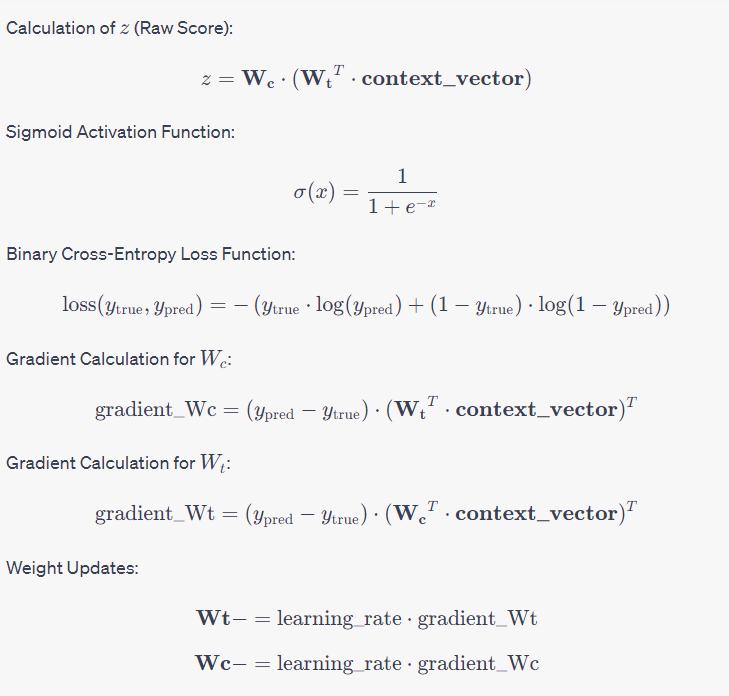

In [90]:
def calculate_tfidf_in_context(sentences, window_size=5):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(sentence) for sentence in sentences])

    context_tfidf = {}

    for sentence in sentences:
        for target_index, target_word in enumerate(sentence):
            context_start = max(0, target_index - window_size)
            context_end = min(len(sentence), target_index + window_size + 1)
            context_words = sentence[context_start:target_index] + sentence[target_index+1:context_end]

            context_tfidf[target_word] = {}

            for word in context_words:
                word_index = tfidf_vectorizer.vocabulary_.get(word, -1)
                if word_index != -1:
                    context_tfidf[target_word][word] = tfidf_matrix[target_index, word_index]

    return context_tfidf

In [94]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import random

corpus = data["text_processed"].tolist()
corpus = ' '.join(corpus)
corpus=corpus.split(".")

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
# embedding_dim = 100


# Mc = tfidf_matrix.toarray()  # Mc
Mc = calculate_tfidf_in_context(corpus, window_size=5)
Wt = (np.random.rand(Mc.shape[1], embedding_dim) - 0.5)  # Wt
Wc = (np.random.rand(Mc.shape[1], embedding_dim) - 0.5)  # Wc


In [95]:
epochs = 100
window_size = 2
learning_rate = 0.01

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Binary Cross-Entropy Loss Function
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Number of sentences to use in each batch
batch_size = 100

# Training the Word2Vec model with Skip-gram on sentences
for epoch in range(epochs):
    total_loss = 0
    shuffled_indices = np.random.permutation(len(corpus))

    for batch_start in range(0, len(corpus), batch_size):
        batch_indices = shuffled_indices[batch_start:batch_start + batch_size]

        for context_sentence_idx in batch_indices:
            context_vector = Mc[context_sentence_idx]
            z = np.dot(Wc, np.dot(Wt.T, context_vector))
            y_pred = sigmoid(z)
            y_true = context_vector
            loss = binary_cross_entropy_loss(y_true, y_pred)

            # Update Wt and Wc using gradient descent

            gradient_Wc = np.dot((y_pred - y_true).reshape(-1, 1), np.dot(Wt.T, context_vector).reshape(-1, 1).T)
            gradient_Wt = np.dot((y_pred - y_true).reshape(-1, 1), np.dot(Wc.T, context_vector).reshape(-1, 1).T)

            Wt -= learning_rate * gradient_Wt
            Wc -= learning_rate * gradient_Wc

            total_loss += loss

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")

    if total_loss <= 0.1:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")
        break


# Evaluation

In [96]:
def sentence_to_vector(sentence, word_to_idx, sentence_vectors, default_vector=None):
    words = sentence.split()
    vector = np.zeros(sentence_vectors.shape[1])
    for word in words:
        if word in word_to_idx:
          vector += sentence_vectors[word_to_idx[word]]


    # Normalize the vector (optional but recommended)
    norm = np.linalg.norm(vector)
    if norm != 0:
        vector /= norm
    return vector


The below predicted senteces are the possible words that can be there in the neighbouring senteces.

In [97]:
new_sentence_1 = "A Practical Way for Parasitics and Noise Tolerance in Analog IMC Circuits"
new_sentence_1=preprocess_text(new_sentence_1)
new_sentence_2 = "Fully analog IMC circuits remove the need for signal converters by realizing both MVM and NLV operations in the analog domain leading to significant energy savings"
new_sentence_2=preprocess_text(new_sentence_2)
vector_1 = sentence_to_vector(new_sentence_1, word_to_idx, sentence_vectors)
vector_2 = sentence_to_vector(new_sentence_2, word_to_idx, sentence_vectors)

# Calculate cosine similarity between sentence and existing sentences
similarities_1 = np.dot(sentence_vectors, vector_1)
similarities_2 = np.dot(sentence_vectors, vector_2)

# Find the most similar sentence for each new sentence
most_similar_sentence_1 = corpus[np.argmax(similarities_1)]
most_similar_sentence_2 = corpus[np.argmax(similarities_2)]

print(f"Most similar sentence to : '{most_similar_sentence_1}'")
print(f"Most similar sentence to : '{most_similar_sentence_2}'")

# Find the most similar sentence for each new sentence
most_disimilar_sentence_1 = corpus[np.argmin(similarities_1)]
most_disimilar_sentence_2 = corpus[np.argmin(similarities_2)]

print(f"Most disimilar sentence to : '{most_disimilar_sentence_1}'")
print(f"Most disimilar sentence to : '{most_disimilar_sentence_2}'")

Most similar sentence to : ' filtering uninformative variables also important knowledge discovery'
Most similar sentence to : ' proposed sic jfet vco serve fundamental building block wireless sensing data communication extreme temperature industrial space applications'
Most disimilar sentence to : ' comparative study outlier detection methods high dimensional text data abstract outlier detection aims find data sample significantly different data samples'
Most disimilar sentence to : ' blockchain based model tracking compliance security requirements increasing threat landscape industrial control systems ics brings different risk profiles comprehensive impacts society safety'


In [98]:
new_sentence_1 = "Energy-efficient routing protocol in wireless sensor networks based on bacterial foraging optimization"
new_sentence_1=preprocess_text(new_sentence_1)
new_sentence_2 = "Seasonal Variations in the Vertical Wavenumber Spectra of Stratospheric Gravity Waves in the Asian Monsoon Region Derived from COSMIC-2 Data"
new_sentence_2=preprocess_text(new_sentence_2)
vector_1 = sentence_to_vector(new_sentence_1, word_to_idx, sentence_vectors)
vector_2 = sentence_to_vector(new_sentence_2, word_to_idx, sentence_vectors)

# Calculate cosine similarity between sentence and existing sentences
similarities_1 = np.dot(sentence_vectors, vector_1)
similarities_2 = np.dot(sentence_vectors, vector_2)

# Find the most similar sentence for each new sentence
most_similar_sentence_1 = corpus[np.argmax(similarities_1)]
most_similar_sentence_2 = corpus[np.argmax(similarities_2)]

print(f"Most similar sentence to : '{most_similar_sentence_1}'")
print(f"Most similar sentence to : '{most_similar_sentence_2}'")

# Find the most similar sentence for each new sentence
most_disimilar_sentence_1 = corpus[np.argmin(similarities_1)]
most_disimilar_sentence_2 = corpus[np.argmin(similarities_2)]

print(f"Most disimilar sentence to : '{most_disimilar_sentence_1}'")
print(f"Most disimilar sentence to : '{most_disimilar_sentence_2}'")

Most similar sentence to : ' miniaturized portable ta probe takes solid step forward translating mtai technology clinical breast tumor diagnosis'
Most similar sentence to : ' following step wrapper wpt constructs final feature vector using boruta algorithm selects discriminant features wide feature pool based important metric obtained random forest classifier'
Most disimilar sentence to : ' eﬃcient accurate computational algorithm based both moving least squares mls ﬁnite diﬀerence fdm methods proposed solving it'
Most disimilar sentence to : ' then personalized pricing method proposed adapt dynamic collaboration process'


In [99]:
new_sentence_1 = "Online Relative Positioning of Autonomous Vehicles Using Signals of Opportunity"
new_sentence_1=preprocess_text(new_sentence_1)
new_sentence_2 = "FPGA-Based Updatable Packet Classification Using TSS-Combined Bit-Selecting Tree"
new_sentence_2=preprocess_text(new_sentence_2)
vector_1 = sentence_to_vector(new_sentence_1, word_to_idx, sentence_vectors)
vector_2 = sentence_to_vector(new_sentence_2, word_to_idx, sentence_vectors)

# Calculate cosine similarity between sentence and existing sentences
similarities_1 = np.dot(sentence_vectors, vector_1)
similarities_2 = np.dot(sentence_vectors, vector_2)

# Find the most similar sentence for each new sentence
most_similar_sentence_1 = corpus[np.argmax(similarities_1)]
most_similar_sentence_2 = corpus[np.argmax(similarities_2)]

print(f"Most similar sentence to : '{most_similar_sentence_1}'")
print(f"Most similar sentence to : '{most_similar_sentence_2}'")

# Find the most similar sentence for each new sentence
most_disimilar_sentence_1 = corpus[np.argmin(similarities_1)]
most_disimilar_sentence_2 = corpus[np.argmin(similarities_2)]

print(f"Most disimilar sentence to : '{most_disimilar_sentence_1}'")
print(f"Most disimilar sentence to : '{most_disimilar_sentence_2}'")

Most similar sentence to : ' cross location activity recognition using adversarial learning human activity recognition har emerging field study recognize human movement actions recorded data'
Most similar sentence to : ' paper problem formulated minimize total energy consumption overall task completion time simultaneously constraints taken consideration'
Most disimilar sentence to : ' issue potentially addressed recent advancement deep learning dl techniques naturally assuming large datasets training'
Most disimilar sentence to : ' alleviate issue leverage explainable artificial intelligence xai paradigm aims improve transparency black box fl decision making process'


Similarly further testing can be done on the further sentences of the test set.